In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from Tutorial.Dataset  import load_scg
from dba.DBA import performDBA

In [2]:
def segmentation(signal, rpeak):
    begin, end = 0, 0
    margin = rpeak[0]
    pieces = []

    for num in range(1, len(rpeak)):
        begin = end
        end = rpeak[num] - margin
        pieces.append(signal[begin: end])
    pieces.append(signal[end:])

    return pieces

In [3]:
def get_features(template, h, d):
    template_peaks_, _ = find_peaks(template, height=np.max(template) * h, distance=len(template) * d)
    template_peaks = []

    if len(template_peaks_) == 2:
        template_peaks = template_peaks_
    elif len(template_peaks_) > 2:
        mmax = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax])
        template_peaks_ = np.delete(template_peaks_, mmax)
        mmax2 = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax2])
    elif len(template_peaks_) < 2:
        # plt.figure()
        # plt.plot(template)
        # plt.scatter(template_peaks_, template[template_peaks_])
        # plt.show()
        return None

    Nmax = len(template)

    dis12 = template_peaks[1] - template_peaks[0]
    dis21 = Nmax - dis12
    A0 = template[template_peaks[0]]
    A1 = template[template_peaks[1]]

    show = False

    if show:
        plt.figure()
        plt.plot(template)
        plt.scatter(template_peaks, template[template_peaks])
        # plt.title(f'dis12/dis21:{dis12/dis21}, A0/A1:{A0/A1}')
        plt.show()

    return [dis12/dis21, A0/A1]

In [10]:
def get_features(template, h, d):
    template_peaks_, _ = find_peaks(template, height=np.max(template) * h, distance=len(template) * d)
    template_peaks = []

    if len(template_peaks_) == 2:
        template_peaks = template_peaks_
    elif len(template_peaks_) > 2:
        mmax = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax])
        template_peaks_ = np.delete(template_peaks_, mmax)
        mmax2 = np.argmax(template[template_peaks_])
        template_peaks.append(template_peaks_[mmax2])
    elif len(template_peaks_) < 2:
        # plt.figure()
        # plt.plot(template)
        # plt.scatter(template_peaks_, template[template_peaks_])
        # plt.show()
        return None

    Nmax = len(template)

    dis12 = template_peaks[1] - template_peaks[0]
    dis21 = Nmax - dis12
    A0 = template[template_peaks[0]]
    A1 = template[template_peaks[1]]

    show = False

    if show:
        plt.figure()
        plt.plot(template)
        plt.scatter(template_peaks, template[template_peaks])
        # plt.title(f'dis12/dis21:{dis12/dis21}, A0/A1:{A0/A1}')
        plt.show()

    return [dis12/dis21, A0/A1]

In [21]:
from tqdm import tqdm
# from dtw.dtw import dtw
import random
def load_(path):
    data = np.load(path)
    signals, labels = data[:, :1000], data[:, 1000:]

    def filter_signals(signals, labels):
        idx = np.any(signals > 1, axis=1)
        return signals[~idx], labels[~idx]

    filtered_signals, filtered_labels = filter_signals(signals, labels)

    return filtered_signals, filtered_labels

if __name__=='__main__':
    signals_0_train, labels_0_train = load_('../../Data/Normal/sim_5000_0_90_140_train_normal.npy')
    signals_0_test, labels_0_test = load_('../../Data/Normal/sim_3000_0_141_178_test_normal.npy')

    def extract_features(signals, labels, alpha, h, d, echo):
        Template_features = []
        idxs = []
        for cnt, signal in tqdm(enumerate(signals)):
            hr = labels[cnt, 2]

            # signal = signal + np.random.normal(size = signal.shape, loc=0, scale=1) * 1e-7
            # np.random.normal(size=signals_0_train.shape, loc=0.0, scale=1.0) * 1e-7
            large_peaks, _ = find_peaks(signal, height=np.max(signal)*0.15, distance=5000//(hr*alpha))
            pieces = segmentation(signal, large_peaks)

            template = performDBA(pieces)
            feature = get_features(template, h, d)
            if feature is None:
                continue
            else:
                Template_features.append(feature)
                idxs.append(cnt)

            show = False
            if show:
                plt.plot(figsize=(10, 2))
                plt.plot(signal)
                plt.show()
                plt.plot(figsize=(10, 2))
                for s in pieces:
                    plt.plot(s, alpha=0.3)
                plt.plot(template, 'r', label='Template-DBA')
                plt.legend()
                plt.show()
            if cnt > echo:
                break

        return np.array(Template_features), np.array(idxs)

    echo_train = 500
    echo_test = 300
    template_features_train, idxs_train = extract_features(signals_0_train, labels_0_train, 1, 0.1, 0.15, echo_train)
    template_features_test, idxs_test = extract_features(signals_0_test, labels_0_test, 1.2, 0.12, 0.12, echo_test)

501it [16:26,  1.97s/it]
301it [09:38,  1.92s/it]


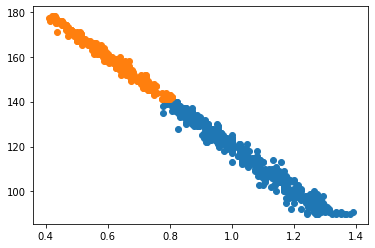

1.7637757684936883
Saved plot to S_Template_DBA_RR.jpg


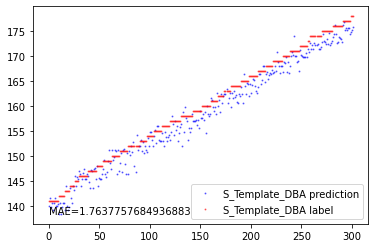

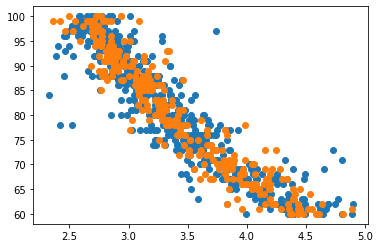

3.1310660346028074
Saved plot to D_Template_DBA_RR.jpg


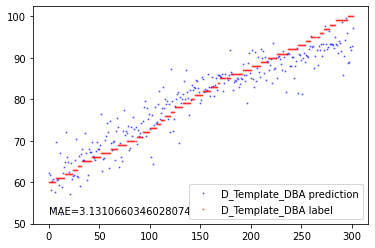

In [24]:
from sklearn.linear_model import LinearRegression as LR
from Tutorial.dsp_utils import plot_2vectors

def plot_plot(features_train, features_test, labels_train, labels_test, title):
    plt.figure()
    plt.scatter(np.array(features_train), labels_train)
    plt.scatter(np.array(features_test), labels_test)
    plt.show()

    reg = LR().fit(np.array(features_train).reshape(-1, 1), labels_train)
    yhat = reg.predict(np.array(features_test).reshape(-1, 1))
    print(np.mean(np.abs(yhat - labels_test)))

    plot_2vectors(labels_test, yhat, True, title, title+'_RR')

plot_plot(template_features_train[idxs_train, 0], template_features_test[idxs_test, 0],labels_0_train[idxs_train, 4], labels_0_test[idxs_test, 4], 'S_Template_DBA')
plot_plot(template_features_train[idxs_train, 1], template_features_test[idxs_test, 1],labels_0_train[idxs_train, 5], labels_0_test[idxs_test, 5], 'D_Template_DBA')